In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 12:00 - loss: 0.1976 - STD: 1.6704e-04 - MAE: 0.4319

 12/632 [..............................] - ETA: 2s - loss: 0.0475 - STD: 2.1011e-04 - MAE: 0.1707   

 24/632 [>.............................] - ETA: 2s - loss: 0.0331 - STD: 1.5692e-04 - MAE: 0.1349

 35/632 [>.............................] - ETA: 2s - loss: 0.0272 - STD: 1.3010e-04 - MAE: 0.1171

 46/632 [=>............................] - ETA: 2s - loss: 0.0238 - STD: 1.1498e-04 - MAE: 0.1052

 56/632 [=>............................] - ETA: 2s - loss: 0.0219 - STD: 1.0977e-04 - MAE: 0.1000

 66/632 [==>...........................] - ETA: 2s - loss: 0.0205 - STD: 1.0921e-04 - MAE: 0.0950

 76/632 [==>...........................] - ETA: 6s - loss: 0.0197 - STD: 1.1439e-04 - MAE: 0.0923

 87/632 [===>..........................] - ETA: 6s - loss: 0.0188 - STD: 1.2604e-04 - MAE: 0.0892

 97/632 [===>..........................] - ETA: 5s - loss: 0.0181 - STD: 1.4578e-04 - MAE: 0.0873

108/632 [====>.........................] - ETA: 5s - loss: 0.0175 - STD: 1.8139e-04 - MAE: 0.0853

119/632 [====>.........................] - ETA: 4s - loss: 0.0171 - STD: 2.4228e-04 - MAE: 0.0838

131/632 [=====>........................] - ETA: 4s - loss: 0.0166 - STD: 3.6940e-04 - MAE: 0.0827

143/632 [=====>........................] - ETA: 4s - loss: 0.0162 - STD: 6.2414e-04 - MAE: 0.0814

155/632 [======>.......................] - ETA: 4s - loss: 0.0159 - STD: 0.0012 - MAE: 0.0804    

167/632 [======>.......................] - ETA: 3s - loss: 0.0155 - STD: 0.0024 - MAE: 0.0791

179/632 [=======>......................] - ETA: 3s - loss: 0.0150 - STD: 0.0047 - MAE: 0.0774

191/632 [========>.....................] - ETA: 3s - loss: 0.0144 - STD: 0.0084 - MAE: 0.0753

203/632 [========>.....................] - ETA: 3s - loss: 0.0137 - STD: 0.0128 - MAE: 0.0731

215/632 [=========>....................] - ETA: 3s - loss: 0.0132 - STD: 0.0171 - MAE: 0.0711

227/632 [=========>....................] - ETA: 2s - loss: 0.0126 - STD: 0.0213 - MAE: 0.0692

239/632 [==========>...................] - ETA: 2s - loss: 0.0121 - STD: 0.0250 - MAE: 0.0675

252/632 [==========>...................] - ETA: 2s - loss: 0.0116 - STD: 0.0288 - MAE: 0.0657

264/632 [===========>..................] - ETA: 2s - loss: 0.0112 - STD: 0.0321 - MAE: 0.0643

277/632 [============>.................] - ETA: 2s - loss: 0.0108 - STD: 0.0351 - MAE: 0.0628

290/632 [============>.................] - ETA: 2s - loss: 0.0104 - STD: 0.0379 - MAE: 0.0614

303/632 [=============>................] - ETA: 2s - loss: 0.0101 - STD: 0.0406 - MAE: 0.0601

316/632 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0431 - MAE: 0.0589

328/632 [==============>...............] - ETA: 1s - loss: 0.0095 - STD: 0.0453 - MAE: 0.0578

341/632 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 0.0474 - MAE: 0.0568

353/632 [===============>..............] - ETA: 1s - loss: 0.0089 - STD: 0.0492 - MAE: 0.0558

364/632 [================>.............] - ETA: 1s - loss: 0.0087 - STD: 0.0508 - MAE: 0.0550

376/632 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 0.0525 - MAE: 0.0542

389/632 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.0541 - MAE: 0.0534

402/632 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.0557 - MAE: 0.0526

414/632 [==================>...........] - ETA: 1s - loss: 0.0079 - STD: 0.0571 - MAE: 0.0519

425/632 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.0582 - MAE: 0.0513

436/632 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.0594 - MAE: 0.0508

447/632 [====================>.........] - ETA: 1s - loss: 0.0074 - STD: 0.0605 - MAE: 0.0502

458/632 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.0616 - MAE: 0.0497

470/632 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0626 - MAE: 0.0492

481/632 [=====================>........] - ETA: 0s - loss: 0.0070 - STD: 0.0636 - MAE: 0.0487

492/632 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0645 - MAE: 0.0482

504/632 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0654 - MAE: 0.0478

515/632 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0663 - MAE: 0.0473

527/632 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0671 - MAE: 0.0469

540/632 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0680 - MAE: 0.0464

552/632 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0687 - MAE: 0.0460

563/632 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0694 - MAE: 0.0457

575/632 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0702 - MAE: 0.0453

588/632 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0710 - MAE: 0.0449

601/632 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0717 - MAE: 0.0446

613/632 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0723 - MAE: 0.0442

625/632 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0729 - MAE: 0.0439

632/632 [==============================] - 5s 6ms/step - loss: 0.0057 - STD: 0.0733 - MAE: 0.0437 - val_loss: 0.0017 - val_STD: 0.0768 - val_MAE: 0.0288


Epoch 2/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.0968 - MAE: 0.0262

 12/632 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273 

 23/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0275

 33/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

 43/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0275

 53/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0276

 64/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1040 - MAE: 0.0278

 74/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0278

 84/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0277

 94/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

105/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

117/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

129/632 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0275

141/632 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

153/632 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

163/632 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

174/632 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

186/632 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

196/632 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

206/632 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

217/632 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

227/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

237/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

249/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

261/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

273/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

285/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

295/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

306/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

316/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

326/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

336/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

347/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

359/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

371/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

383/632 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

395/632 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

407/632 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

419/632 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

432/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

444/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

456/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

468/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

481/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

493/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

506/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

519/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

531/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

544/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

557/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

569/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

580/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

590/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

600/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

610/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

621/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

632/632 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271 - val_loss: 0.0021 - val_STD: 0.0831 - val_MAE: 0.0314


Epoch 3/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0271

 13/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265 

 25/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

 37/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

 49/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0272

 62/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

 75/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

 87/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

 96/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

106/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

116/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

127/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

139/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

149/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

159/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

169/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

180/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

192/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

204/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

215/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

227/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

240/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

252/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

264/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

275/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

285/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

297/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

309/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

321/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

334/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

345/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

355/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

365/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

375/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

386/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

398/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

410/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

421/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

432/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

442/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

453/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

464/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

474/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

484/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

495/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

506/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

518/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

530/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

542/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

554/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

566/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

578/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

591/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

603/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

616/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

628/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262 - val_loss: 0.0014 - val_STD: 0.0766 - val_MAE: 0.0269


Epoch 4/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0014 - STD: 0.0970 - MAE: 0.0261

 13/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0263 

 25/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1040 - MAE: 0.0262

 36/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

 48/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0259

 60/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0260

 72/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

 84/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

 96/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

108/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0261

120/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

132/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

144/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

156/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

168/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

180/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

192/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

204/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

216/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

228/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

240/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

252/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

264/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

276/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

288/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

299/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

309/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

320/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

330/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

341/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

351/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

362/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

374/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

385/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

397/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

409/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

421/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

433/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

445/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

457/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

469/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

481/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

493/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

505/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

517/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

529/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

541/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

553/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

565/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

577/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

589/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

601/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

613/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

625/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259 - val_loss: 0.0015 - val_STD: 0.0815 - val_MAE: 0.0276


Epoch 5/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251 

 22/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

 33/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0253

 44/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0254

 55/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0256

 67/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

 79/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0254

 91/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0254

102/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0254

114/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

126/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0253

139/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

151/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

163/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

175/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

187/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

199/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0254

211/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0254

222/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0254

234/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0254

244/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0254

254/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0254

265/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0254

277/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0254

288/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0254

298/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0253

309/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0253

321/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0253

333/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0253

345/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0254

357/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0254

369/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0254

381/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0254

392/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0254

402/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0254

414/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0254

426/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0254

438/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0254

448/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

459/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

471/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

483/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

495/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

506/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

518/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

530/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

543/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

555/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

567/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

579/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

592/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

604/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

616/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

628/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254 - val_loss: 0.0014 - val_STD: 0.0805 - val_MAE: 0.0267


Epoch 6/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0013 - STD: 0.1012 - MAE: 0.0242

 13/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0250 

 25/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0248

 37/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1052 - MAE: 0.0249

 49/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0249

 62/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

 74/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

 87/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0254

100/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0257

112/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

124/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

136/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

148/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

160/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

172/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

184/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0255

196/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

209/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

221/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0254

234/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

246/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0254

258/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

270/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

282/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

293/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

304/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

317/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

329/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

341/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

353/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

365/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

377/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

389/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

400/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

411/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

421/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

431/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

441/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

451/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

461/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

472/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

484/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

496/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

508/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

520/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

532/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

543/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

553/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

564/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

576/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

588/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

600/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

612/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

624/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252 - val_loss: 0.0015 - val_STD: 0.0837 - val_MAE: 0.0270


Epoch 7/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0246

 13/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1049 - MAE: 0.0252 

 25/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

 37/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

 49/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0247

 60/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

 70/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

 80/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0250

 91/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

102/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0248

115/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

127/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

139/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

150/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

160/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

172/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

184/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

196/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

208/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

220/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

231/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

241/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

252/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

262/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0246

274/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

286/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

297/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

309/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

321/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

333/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

345/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

357/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0246

369/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0245

381/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0245

392/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0245

403/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0245

413/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0245

424/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0245

436/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0245

448/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0245

460/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0245

472/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0245

484/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0245

496/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0245

508/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0245

519/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0245

531/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

542/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

553/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

563/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

572/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

582/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

593/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

605/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

617/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

629/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244 - val_loss: 0.0027 - val_STD: 0.0909 - val_MAE: 0.0342


Epoch 8/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0014 - STD: 0.1143 - MAE: 0.0266

 11/632 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1082 - MAE: 0.0264 

 23/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

 35/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

 47/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0253

 59/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

 71/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0248

 83/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0248

 95/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0247

107/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0246

119/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1058 - MAE: 0.0245

131/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0245

143/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0244

154/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0244

164/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0244

175/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0243

186/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0243

196/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0244

206/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0244

218/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0245

230/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0245

242/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0245

254/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0245

265/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0245

277/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0244

289/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0244

301/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0244

313/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0244

325/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0243

337/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0243

349/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0243

360/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0243

371/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0243

382/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0243

392/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0243

402/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0244

412/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

423/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

433/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

444/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

455/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

465/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

475/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

486/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

496/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

506/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0244

516/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

526/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

536/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

546/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

556/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

566/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

577/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

588/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

598/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

608/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

618/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

628/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243 - val_loss: 0.0021 - val_STD: 0.0885 - val_MAE: 0.0309


Epoch 9/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0013 - STD: 0.1130 - MAE: 0.0242

 11/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235 

 21/632 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1083 - MAE: 0.0235

 31/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0240

 41/632 [>.............................] - ETA: 3s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0242

 51/632 [=>............................] - ETA: 3s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

 61/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0242

 71/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

 81/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0244

 91/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

101/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0245

111/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0245

121/632 [====>.........................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

131/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0244

141/632 [=====>........................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

151/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

162/632 [======>.......................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

172/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

182/632 [=======>......................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

193/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

203/632 [========>.....................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

213/632 [=========>....................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

223/632 [=========>....................] - ETA: 2s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

233/632 [==========>...................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

243/632 [==========>...................] - ETA: 2s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

253/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0241

263/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0241

273/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0241

283/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

294/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0240

304/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

314/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0240

325/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0240

337/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0240

349/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0240

361/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0240

373/632 [================>.............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0240

385/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0239

397/632 [=================>............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

409/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0239

421/632 [==================>...........] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

433/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

445/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

457/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

469/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

481/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

493/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

504/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

516/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238

528/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

540/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

552/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

564/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

576/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

588/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

600/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

612/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

624/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238

632/632 [==============================] - 3s 5ms/step - loss: 0.0012 - STD: 0.1071 - MAE: 0.0238 - val_loss: 0.0020 - val_STD: 0.0838 - val_MAE: 0.0324


Epoch 10/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1016 - MAE: 0.0258

 12/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241 

 24/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0237

 36/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0236

 48/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0236

 60/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

 71/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0235

 83/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0234

 95/632 [===>..........................] - ETA: 2s - loss: 0.0011 - STD: 0.1065 - MAE: 0.0234

107/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0234

118/632 [====>.........................] - ETA: 2s - loss: 0.0011 - STD: 0.1066 - MAE: 0.0234

130/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1067 - MAE: 0.0234

142/632 [=====>........................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0234

154/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

166/632 [======>.......................] - ETA: 2s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

177/632 [=======>......................] - ETA: 2s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0234

188/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0234

199/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0234

211/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

222/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

232/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

242/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

252/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

263/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

274/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

286/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

299/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

311/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

323/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

335/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

347/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

358/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

369/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

380/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233

391/632 [=================>............] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

402/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

412/632 [==================>...........] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

423/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

434/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

445/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

456/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

468/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

479/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

490/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

502/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

513/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

523/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

535/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

547/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

559/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0233

570/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

582/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

594/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

606/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

618/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

630/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0233

632/632 [==============================] - 3s 5ms/step - loss: 0.0011 - STD: 0.1074 - MAE: 0.0233 - val_loss: 0.0016 - val_STD: 0.0850 - val_MAE: 0.0271


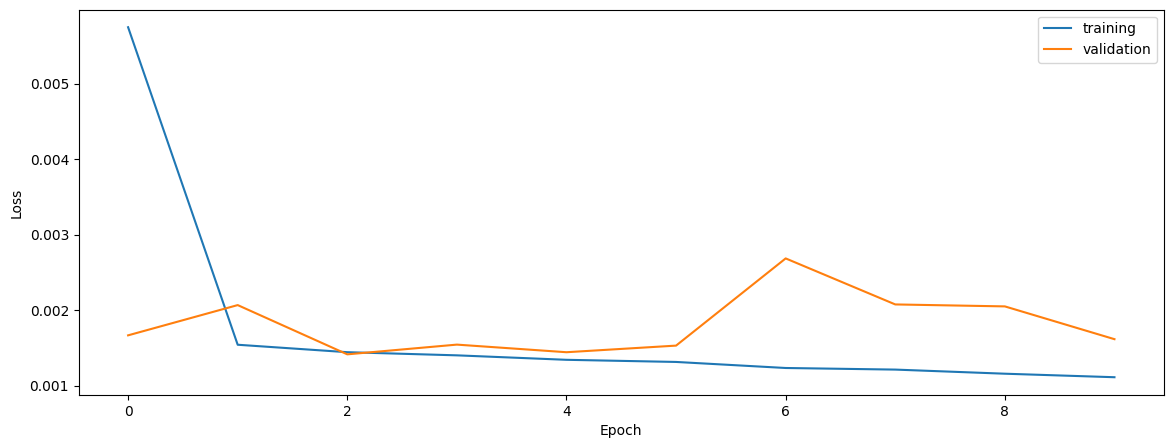

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9447926504417701
0.9571437473853943
0.9501051227318666


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.945464314068311
0.9539196854262252
0.9515692584537666


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9521162263772432
0.9558220036255317
0.9628493378087377


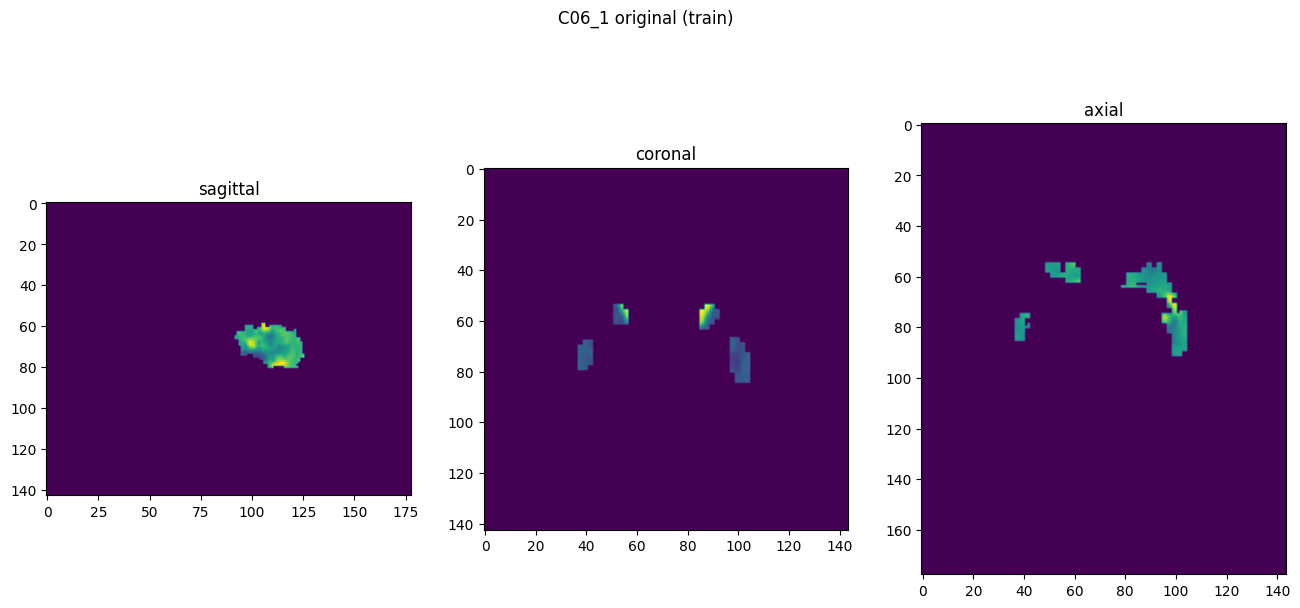

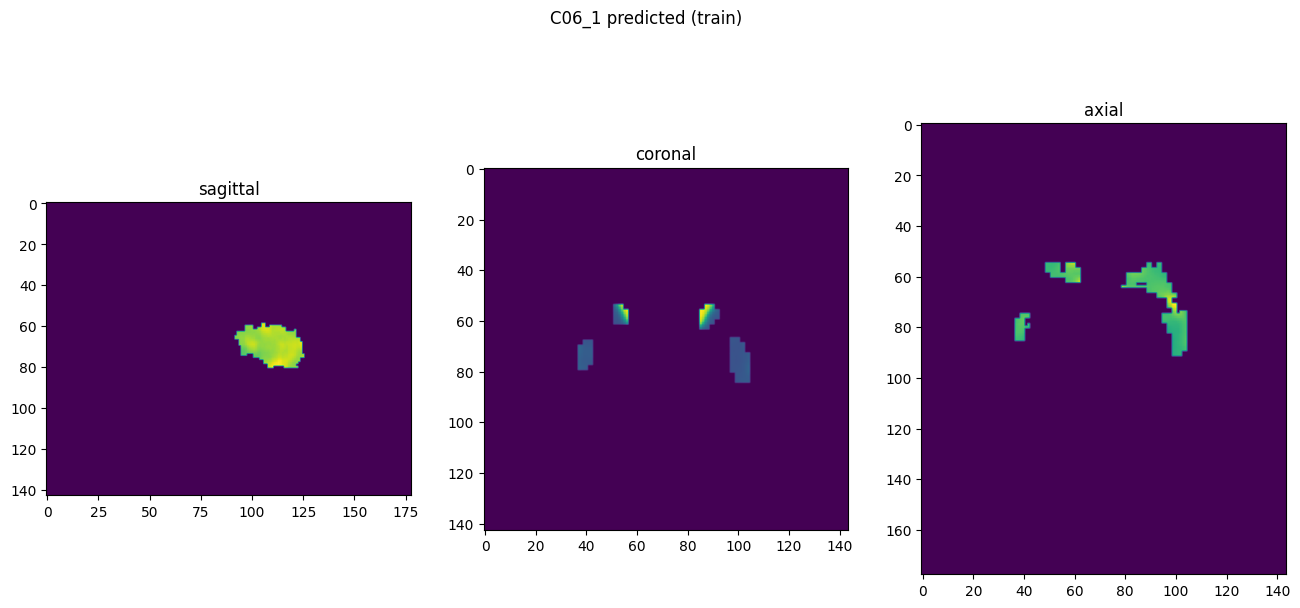

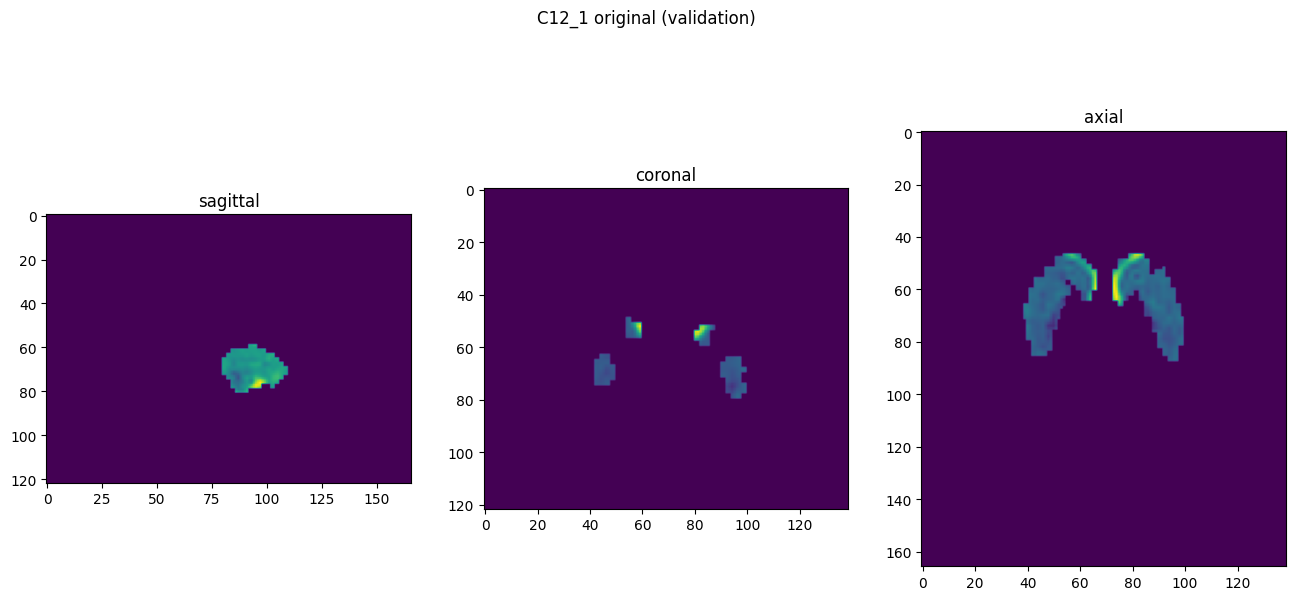

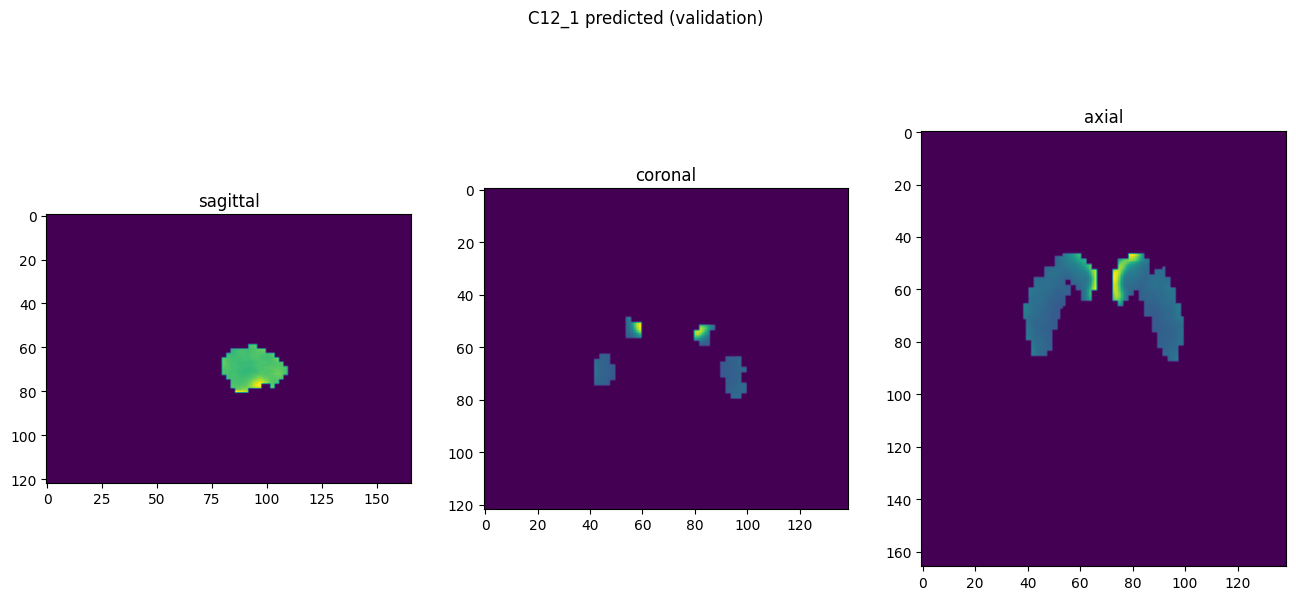

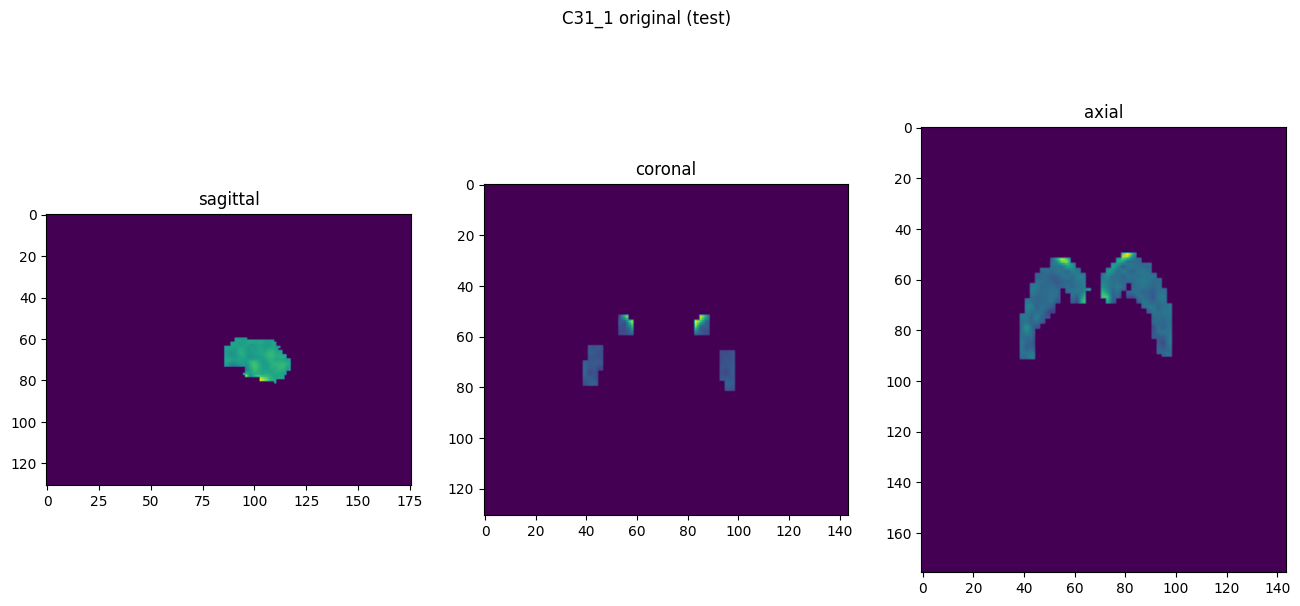

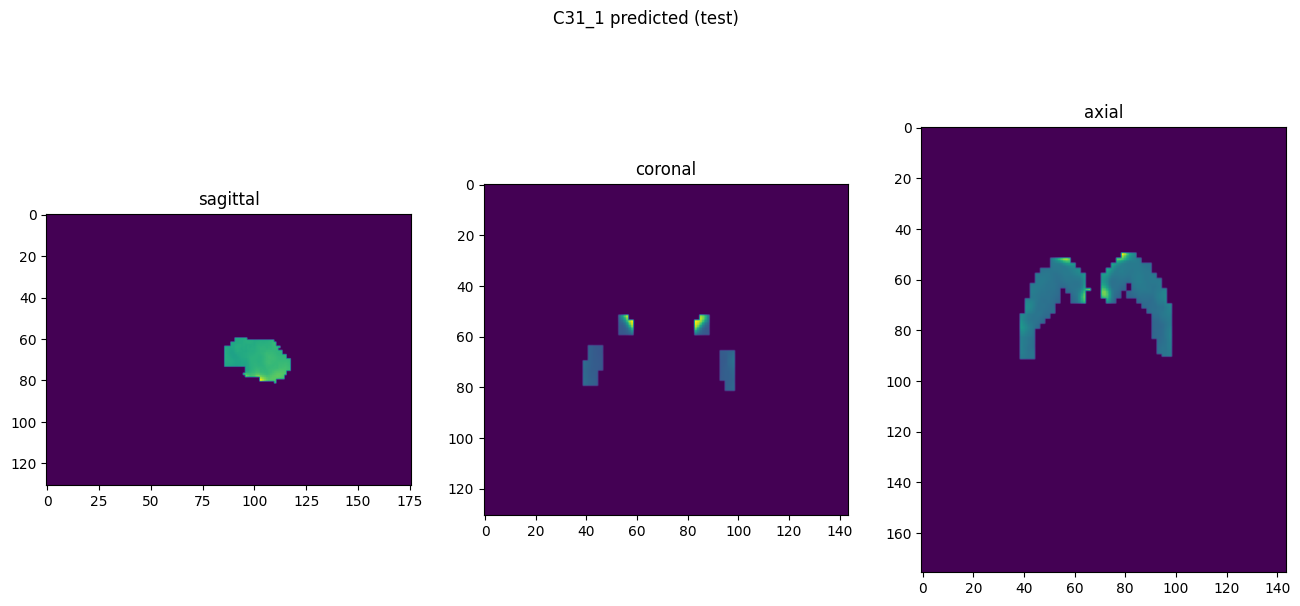

In [10]:
showResults(model, gen, threshold=None, background=False)